# Create dataset

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import colorsys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
files = [file for file in os.listdir("./LGA_data") if file.endswith(".xls")]
all_files = pd.DataFrame()

for file in files:
    df = pd.read_excel("./LGA_data/" + file)
    all_files = pd.concat([all_files, df])

C:\Users\johnn\AppData\Local\Temp\ipykernel_4596\912865602.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_files = pd.concat([all_files, df])


# Preprocessing and filtering

In [3]:
num_rows = all_files.shape[0]
print("Number of rows before cleaning:", num_rows)
all_files.dropna(subset=['Street Display'], inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping NAs:", num_rows)
all_files.drop_duplicates(inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping duplicates:", num_rows)
# Find the indices of the rows with sale price equal to 0
indices_to_drop = all_files[all_files['Sale Price'] == 0].index
# Drop the rows from the dataset
all_files.drop(indices_to_drop, inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping obs with sales price = 0:", num_rows)


Number of rows before cleaning: 874193
Number of rows after dropping NAs: 873680
Number of rows after dropping duplicates: 873610
Number of rows after dropping obs with sales price = 0: 526075


In [4]:
all_files = all_files.reset_index(drop=True)
df = all_files
# df.to_csv('alldata.csv', index=False)

In [5]:
df.columns

Index(['Disclaimer', 'Building Name', 'Street Display',
       'Alternate Street Display', 'Other', 'Unit', 'Number', 'Street Name',
       'Locality', 'Postcode', 'Alt. Street', 'Alt. Locality',
       'Legal Description', 'Volume/Folio', 'Vendor Names', 'Vendor Address',
       'Purchaser Names', 'Purchaser Address', 'Volume Folio', 'Parish',
       'Office Name', 'Agent Name', 'First Price', 'Change %', 'Last Price',
       'Change %.1', 'Days To Sell', 'Sale Price', 'Sale Date',
       'Settlement Date', 'Sale Type', 'Area', 'Building Area', 'Bedrooms',
       'Bathrooms', 'Car Parks', 'Property Type', 'Land Use', 'Zoning',
       'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type',
       'Roof Type', 'Improvements', 'Hundred', 'Sale Category',
       'Document Status', 'Parties Related Flag', 'Parties Related',
       'Valuation Date', 'Valuation Amount', 'LGA', 'Dealing Number',
       'Government Number', 'Parent Government Number', 'PDS ID', 'Sale ID',
       

In [6]:
# Drop columns: 'Disclaimer', 'Building Name' and 25 other columns
df = df.drop(columns=['Disclaimer', 'Building Name', 'Alternate Street Display', 'Other', 'Alt. Street', 'Alt. Locality', 'Volume/Folio', 'Volume Folio', 'Parish', 'Building Area', 'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type', 'Roof Type', 'Improvements', 'Hundred', 'Sale Category', 'Document Status', 'Parties Related Flag', 'Parties Related', 'Valuation Date', 'Valuation Amount', 'Parent Government Number', 'Load Date', 'Property ID'])

df = df[df["Property Type"] != "Commercial"]
df = df[df["Property Type"] != "Industrial"]
df = df[df["Property Type"] != "Other"]

df = df[df['Bedrooms'] <= 10]
df = df[df['Car Parks'] <= 10]
df = df[df['Area'] <= 1000]
df = df[df['Bathrooms'] <= 10]

df = df[df['Sale Price'] <= 10000000]

In [7]:
df.dtypes

Street Display               object
Unit                        float64
Number                       object
Street Name                  object
Locality                     object
Postcode                    float64
Legal Description            object
Vendor Names                 object
Vendor Address               object
Purchaser Names              object
Purchaser Address            object
Office Name                  object
Agent Name                   object
First Price                  object
Change %                    float64
Last Price                   object
Change %.1                  float64
Days To Sell                float64
Sale Price                  float64
Sale Date            datetime64[ns]
Settlement Date      datetime64[ns]
Sale Type                    object
Area                        float64
Bedrooms                    float64
Bathrooms                   float64
Car Parks                   float64
Property Type                object
Land Use                    

# Analysis

## Median sales price year on year by Locality 

In [16]:
import pandas as pd
import numpy as np

def make_summary(df):
    # 1. Ensure Sale Date is datetime and extract Year
    df = df.copy()
    df['Sale Date'] = pd.to_datetime(df['Sale Date'])
    df['Year'] = df['Sale Date'].dt.year

    # 2. Compute counts per Locality per Year and filter out low-volume localities
    counts = (
        df
        .groupby(['Locality','Year'])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    valid_locs = counts[counts.min(axis=1) >= 10].index
    df = df[df['Locality'].isin(valid_locs)]

    # 3. Compute median Sale Price per Locality per Year
    median_prices = (
        df
        .groupby(['Locality', 'Year'])['Sale Price']
        .median()
        .unstack(fill_value=np.nan)
        .sort_index(axis=1)
    )
    median_prices.columns = [f'Median_{year}' for year in median_prices.columns]

    # 4. Compute year-on-year growth rates
    years = sorted(int(col.replace('Median_', '')) for col in median_prices.columns)
    growth_rates = pd.DataFrame(index=median_prices.index)
    for prev, curr in zip(years, years[1:]):
        p, c = f'Median_{prev}', f'Median_{curr}'
        growth_rates[f'Growth_{prev}-{curr}'] = (
            median_prices[c] - median_prices[p]
        ) / median_prices[p]

    # 5. Combine medians and growth rates
    summary = pd.concat([median_prices, growth_rates], axis=1)

    # 6. Drop the 2018 median column (if present) and any rows with missing data
    summary = summary.drop(columns=['Median_2018'], errors='ignore')
    summary = summary.dropna(how='any')

    return summary

# 7. Split and generate summaries
df_house = df[df['Property Type'] == 'House']
summary_house = make_summary(df_house)
print("House Summary:")
print(summary_house)

df_unit = df[df['Property Type'] == 'Unit']
summary_unit = make_summary(df_unit)
print("\nUnit Summary:")
print(summary_unit)


House Summary:
                      Median_2019  Median_2020  Median_2021  Median_2022  \
Locality                                                                   
ABERGLASSLYN             478750.0     519900.0     611000.0     720000.0   
ACACIA GARDENS           790000.0     844500.0    1120000.0    1170000.0   
ADAMSTOWN                672500.0     725000.0     890000.0    1048000.0   
ADAMSTOWN HEIGHTS        717500.0     745000.0     935000.0    1045000.0   
ALBION PARK              600000.0     629000.0     733000.0     840000.0   
ALLAMBIE HEIGHTS        1700000.0    1785000.0    2455000.0    2325000.0   
AMBARVALE                540000.0     580000.0     712500.0     792500.0   
ANNANDALE               1940000.0    1937500.0    2595000.0    2362500.0   
ARNCLIFFE               1100000.0    1310000.0    1570000.0    1402500.0   
ASHFIELD                1450000.0    1577500.0    2100000.0    1800000.0   
ASHTONFIELD              582000.0     570000.0     660000.0     745000.0 

### Sorted by top performing Localities with median price <1M

In [22]:
# 9a. Filter House summary where Median_2023 ≤ $1,000,000
filtered_house = summary_house[summary_house['Median_2023'] <= 1_000_000]

# 10a. Top 10 House localities by Growth_2022-2023
top10_house = (
    filtered_house
    .sort_values(by='Growth_2022-2023', ascending=False)
    .head(10)
)
print("Top 10 Houses by 2022–23 Growth:")
print(top10_house)

# 9b. Filter Unit summary where Median_2023 ≤ $1,000,000
filtered_unit = summary_unit[summary_unit['Median_2023'] <= 1_000_000]

# 10b. Top 10 Unit localities by Growth_2022-2023
top10_unit = (
    filtered_unit
    .sort_values(by='Growth_2022-2023', ascending=False)
    .head(10)
)
print("\nTop 10 Units by 2022–23 Growth:")
print(top10_unit)

Top 10 Houses by 2022–23 Growth:
                 Median_2019  Median_2020  Median_2021  Median_2022  \
Locality                                                              
LAKE CATHIE         582000.0     647500.0     819000.0     792500.0   
NORAVILLE           528500.0     587500.0     806000.0     760000.0   
BERKELEY            462500.0     557500.0     699000.0     700000.0   
DEAN PARK           600000.0     677500.0     750000.0     780000.0   
BELMONT             645000.0     615000.0     810000.0     855000.0   
SOUTH TAMWORTH      250000.0     251250.0     310000.0     375000.0   
ASHTONFIELD         582000.0     570000.0     660000.0     745000.0   
WYONG               480000.0     635000.0     716500.0     720000.0   
RAYMOND TERRACE     385000.0     415000.0     498500.0     615000.0   
MAYFIELD EAST       536000.0     669000.0     843750.0     890000.0   

                 Median_2023  Growth_2018-2019  Growth_2019-2020  \
Locality                                      

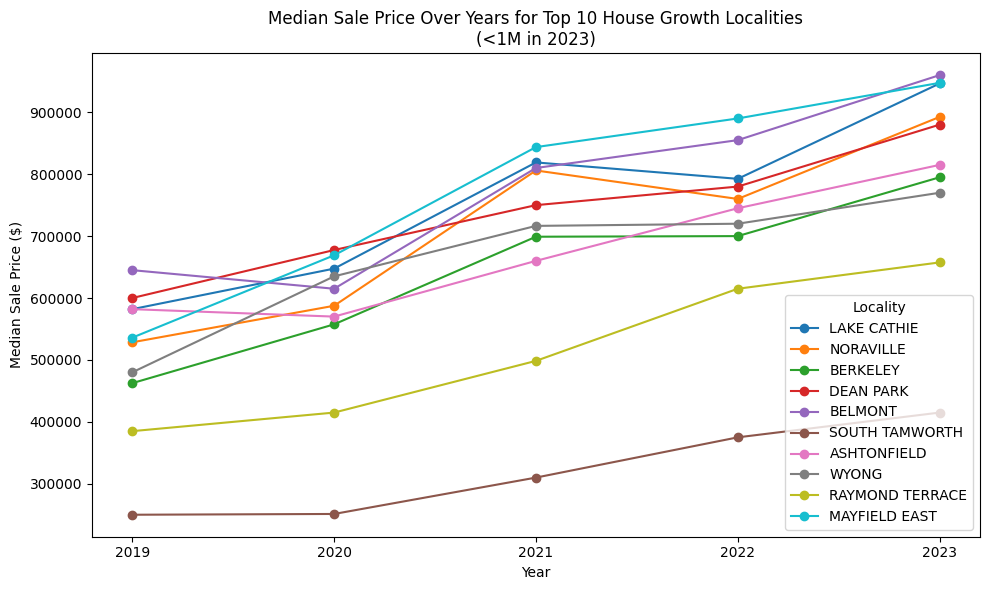

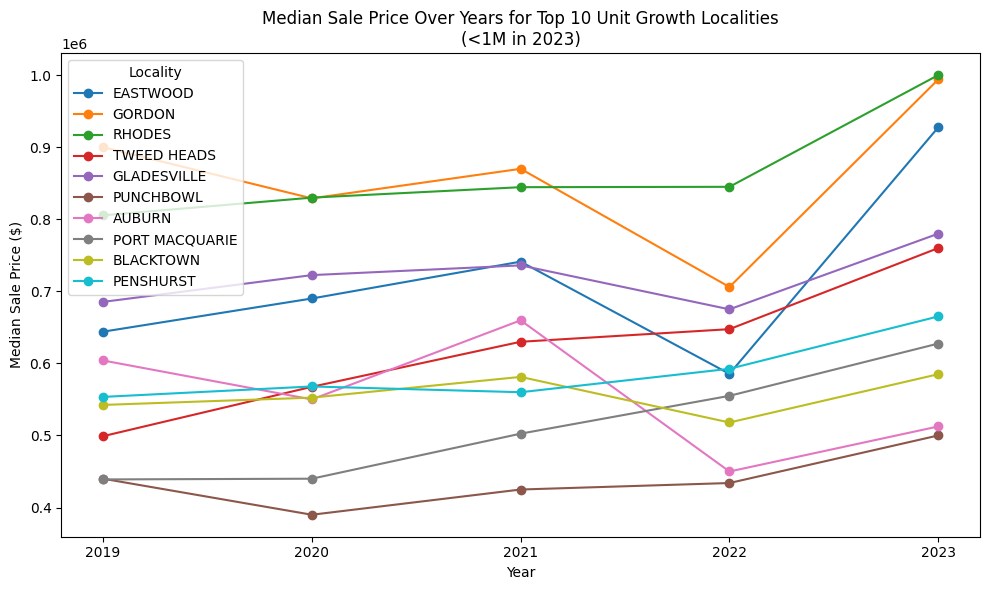

In [23]:
import matplotlib.pyplot as plt

def plot_top10_growth(top10_df, property_type):
    # Identify and sort the median‐price columns by year
    median_cols = sorted(
        [c for c in top10_df.columns if c.startswith('Median_')],
        key=lambda x: int(x.split('_')[1])
    )
    years = [int(c.split('_')[1]) for c in median_cols]

    # Plot each locality’s median price over time
    plt.figure(figsize=(10, 6))
    for locality in top10_df.index:
        plt.plot(
            years,
            top10_df.loc[locality, median_cols].values,
            marker='o',
            label=locality
        )

    # Chart formatting
    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(
        f'Median Sale Price Over Years for Top 10 {property_type} Growth Localities\n(<1M in 2023)'
    )
    plt.xticks(years)
    plt.legend(title='Locality')
    plt.tight_layout()
    plt.show()

# Plot for Houses
plot_top10_growth(top10_house, 'House')

# Plot for Units
plot_top10_growth(top10_unit, 'Unit')

## Plotting distributions of house price growth rates against unit price growth rates (are unit growth rates worse than houses?)

House growth 2022–23: mean = -0.013762868785807585 median = -0.0120608952510793 n = 384
Unit  growth 2022–23: mean = 0.019388298521596913 median = 0.0 n = 96


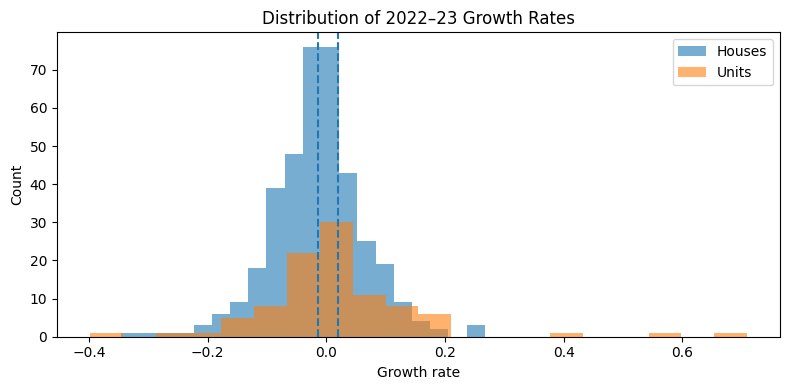

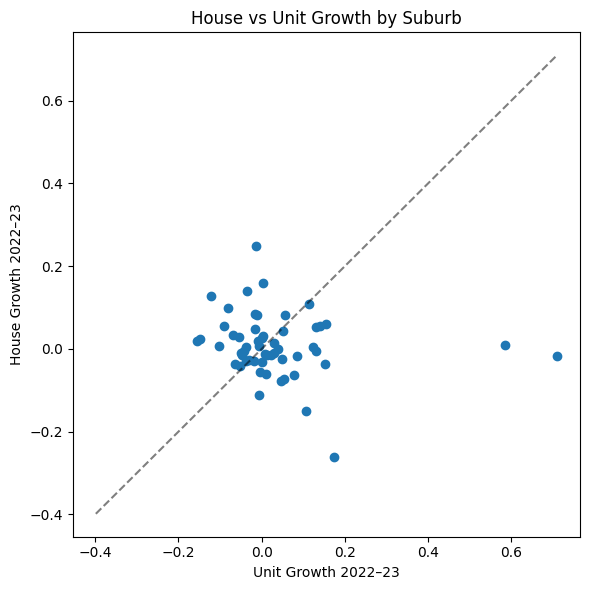

Paired t-test (H vs U): t=-1.033, p=0.306


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  # for t-test, if you want

# 1. Pull out the 2022–23 growth series
h_growth = summary_house['Growth_2022-2023']
u_growth = summary_unit ['Growth_2022-2023']

# 2. Basic summaries
print("House growth 2022–23: mean =", h_growth.mean(), 
      "median =", h_growth.median(), "n =", len(h_growth))
print("Unit  growth 2022–23: mean =", u_growth.mean(), 
      "median =", u_growth.median(), "n =", len(u_growth))

# 3. Visualise distributions
plt.figure(figsize=(8,4))
plt.hist(h_growth, bins=20, alpha=0.6, label='Houses')
plt.hist(u_growth, bins=20, alpha=0.6, label='Units')
plt.axvline(h_growth.mean(), linestyle='--')
plt.axvline(u_growth.mean(), linestyle='--')
plt.legend()
plt.title('Distribution of 2022–23 Growth Rates')
plt.xlabel('Growth rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4. Scatter: House vs Unit on a per-suburb basis
#    Only for suburbs that exist in both summaries:
common = summary_house.index.intersection(summary_unit.index)
plt.figure(figsize=(6,6))
plt.scatter(u_growth.loc[common], h_growth.loc[common])
lims = [min(u_growth.min(), h_growth.min()), max(u_growth.max(), h_growth.max())]
plt.plot(lims, lims, 'k--', alpha=0.5)
plt.xlabel('Unit Growth 2022–23')
plt.ylabel('House Growth 2022–23')
plt.title('House vs Unit Growth by Suburb')
plt.tight_layout()
plt.show()

# 5. (Optional) Paired t-test
tstat, pval = stats.ttest_rel(h_growth.loc[common], u_growth.loc[common])
print(f"Paired t-test (H vs U): t={tstat:.3f}, p={pval:.3f}")


In [25]:
import pandas as pd
from scipy import stats

# 1. Identify all growth columns in your summaries
growth_cols = [c for c in summary_house.columns if c.startswith('Growth_')]

# 2. Restrict to the same set of suburbs in both tables
common = summary_house.index.intersection(summary_unit.index)

# 3. Collect results
results = []
for col in growth_cols:
    h = summary_house.loc[common, col]
    u = summary_unit.loc[common, col]
    
    # Paired t-test
    tstat, pval = stats.ttest_rel(h, u)
    
    results.append({
        'Period': col.replace('Growth_', ''),
        'House mean': h.mean(),
        'Unit mean': u.mean(),
        't-stat': tstat,
        'p-value': pval
    })

# 4. Build a results DataFrame
results_df = pd.DataFrame(results).set_index('Period')

print(results_df)


           House mean  Unit mean     t-stat       p-value
Period                                                   
2018-2019   -0.008479  -0.045370   2.215078  3.099319e-02
2019-2020    0.108202   0.067003   2.349298  2.249648e-02
2020-2021    0.254702   0.066080  10.221968  3.125769e-14
2021-2022    0.021775  -0.013316   2.460664  1.709684e-02
2022-2023    0.008014   0.032177  -1.033039  3.061904e-01


Growth difference between houses and units is statistically significant in all years except 2022-23.

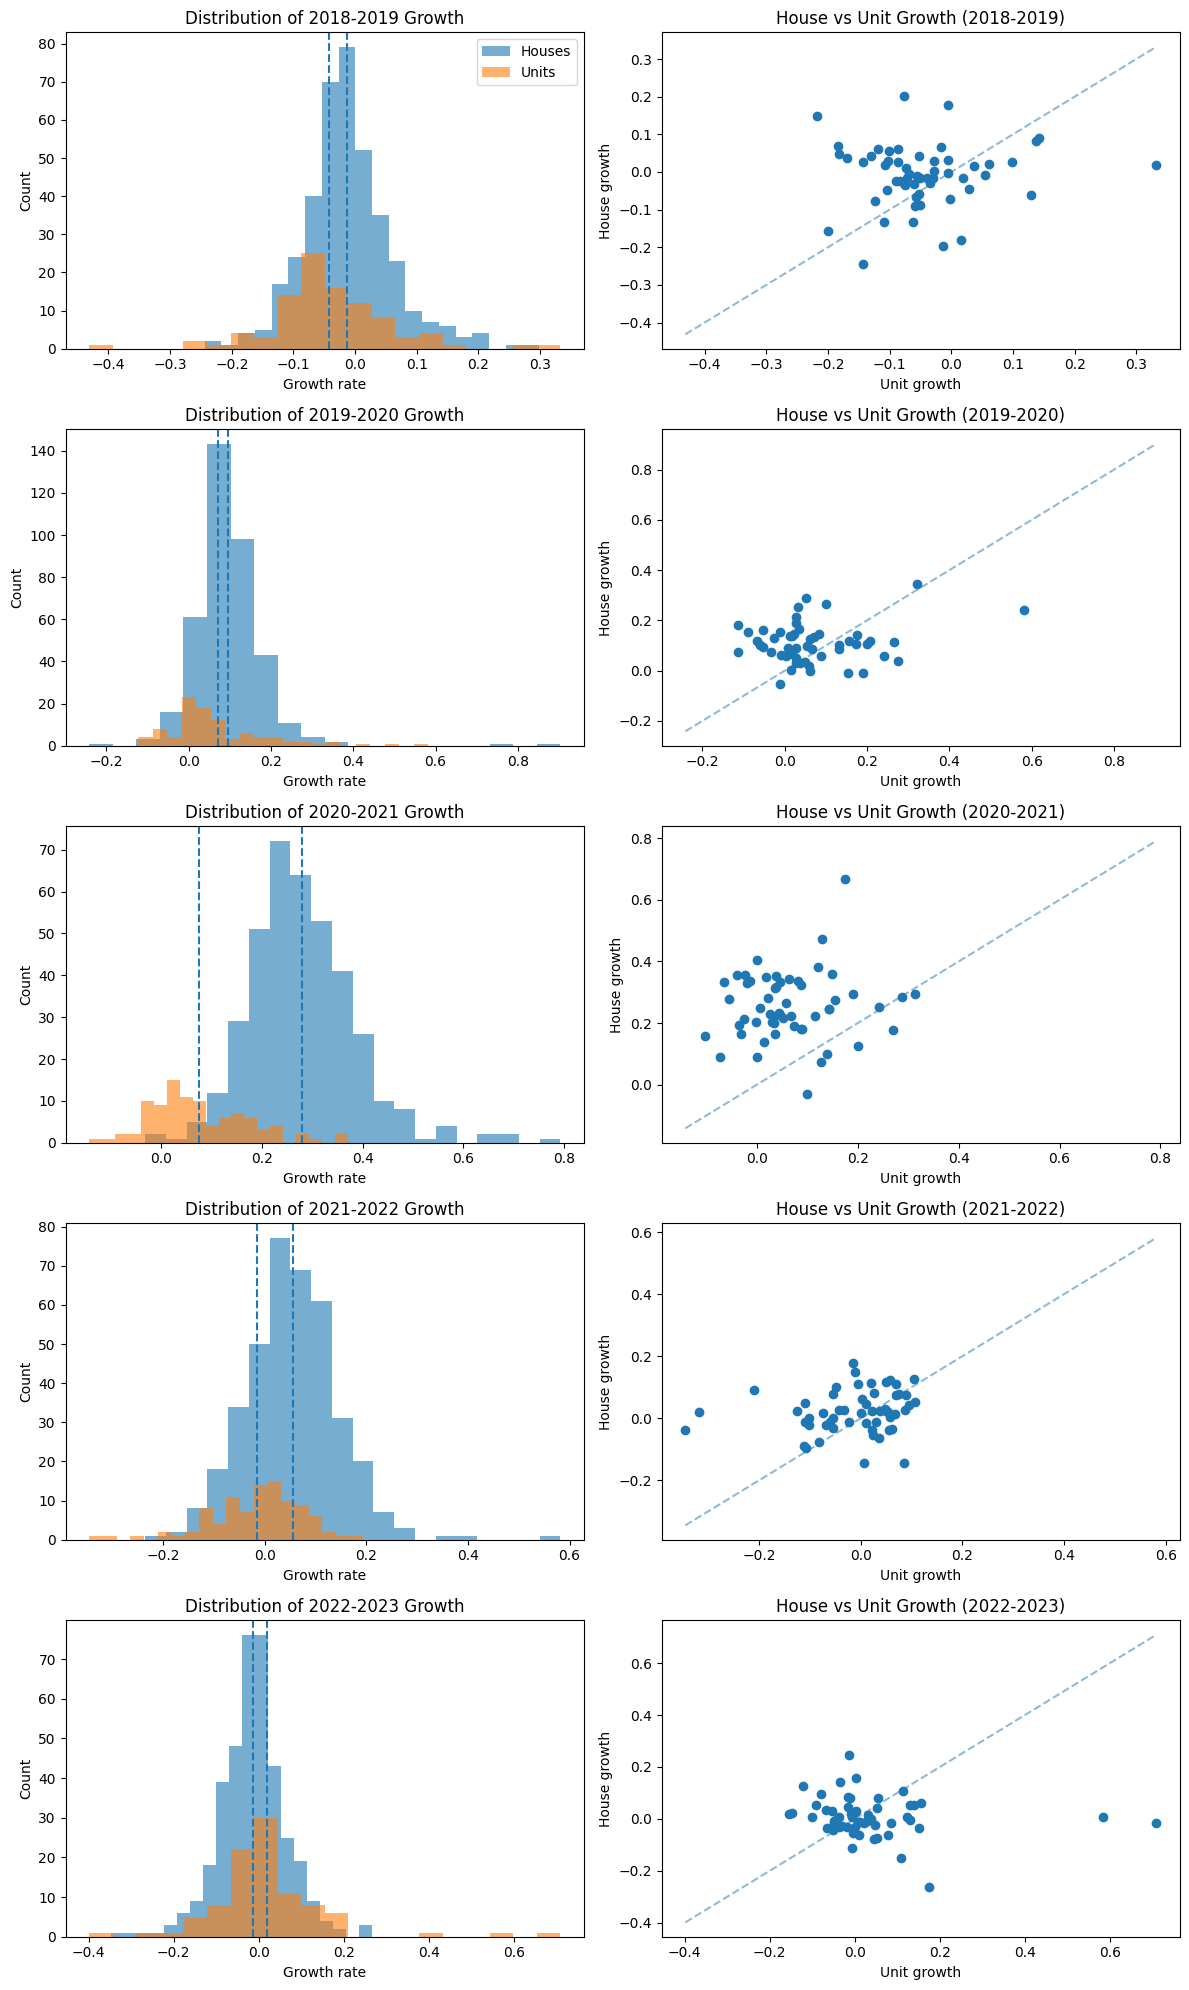

In [ ]:
import matplotlib.pyplot as plt

# 1. Grab all your “Growth_YYYY–YYYY” columns
growth_cols = [c for c in summary_house.columns if c.startswith('Growth_')]

# 2. Find the suburbs common to both series (for scatter plots)
common = summary_house.index.intersection(summary_unit.index)

# 3. Create a figure: one row per period, 2 columns (histogram | scatter)
n = len(growth_cols)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, col in enumerate(growth_cols):
    period = col.replace('Growth_', '')
    
    # --- Left: overlaid histograms ---
    ax = axes[i, 0]
    ax.hist(summary_house[col], bins=20, alpha=0.6, label='Houses')
    ax.hist(summary_unit[col],  bins=20, alpha=0.6, label='Units')
    ax.axvline(summary_house[col].mean(), linestyle='--')
    ax.axvline(summary_unit[col].mean(), linestyle='--')
    ax.set_title(f'Distribution of {period} Growth')
    if i == 0:
        ax.legend()
    ax.set_xlabel('Growth rate')
    ax.set_ylabel('Count')
    
    # --- Right: House vs Unit scatter ---
    ax2 = axes[i, 1]
    ax2.scatter(summary_unit.loc[common, col],
                summary_house.loc[common, col])
    lims = [
        min(summary_unit[col].min(), summary_house[col].min()),
        max(summary_unit[col].max(), summary_house[col].max())
    ]
    ax2.plot(lims, lims, linestyle='--', alpha=0.5)
    ax2.set_title(f'House vs Unit Growth ({period})')
    ax2.set_xlabel('Unit growth')
    ax2.set_ylabel('House growth')

plt.tight_layout()
plt.show()
